In [457]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Read the dataset
df = pd.read_csv('train_dataset_final1.csv')
df.head()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017,2,0,2,60000,25.0,2,2,2,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,5018,2,1,1,290000,24.0,0,0,-2,-2,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,5019,1,0,2,180000,63.0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,5020,1,1,2,210000,43.0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,5021,2,0,1,280000,32.0,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


In [458]:
print(df.shape)
print(df.info())
print(df.describe())

(25247, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25247 entries, 0 to 25246
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         25247 non-null  int64  
 1   marriage            25247 non-null  int64  
 2   sex                 25247 non-null  int64  
 3   education           25247 non-null  int64  
 4   LIMIT_BAL           25247 non-null  int64  
 5   age                 25121 non-null  float64
 6   pay_0               25247 non-null  int64  
 7   pay_2               25247 non-null  int64  
 8   pay_3               25247 non-null  int64  
 9   pay_4               25247 non-null  int64  
 10  pay_5               25247 non-null  int64  
 11  pay_6               25247 non-null  int64  
 12  Bill_amt1           25247 non-null  float64
 13  Bill_amt2           25247 non-null  float64
 14  Bill_amt3           25247 non-null  float64
 15  Bill_amt4           25247 non-null  float

In [459]:
# Missing values
print(df.isnull().sum())

#in age replace nulls with mean
df['age'].fillna(df['age'].median(), inplace=True)

Customer_ID             0
marriage                0
sex                     0
education               0
LIMIT_BAL               0
age                   126
pay_0                   0
pay_2                   0
pay_3                   0
pay_4                   0
pay_5                   0
pay_6                   0
Bill_amt1               0
Bill_amt2               0
Bill_amt3               0
Bill_amt4               0
Bill_amt5               0
Bill_amt6               0
pay_amt1                0
pay_amt2                0
pay_amt3                0
pay_amt4                0
pay_amt5                0
pay_amt6                0
AVG_Bill_amt            0
PAY_TO_BILL_ratio       0
next_month_default      0
dtype: int64


C:\Users\krish\AppData\Local\Temp\ipykernel_144924\282367700.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)


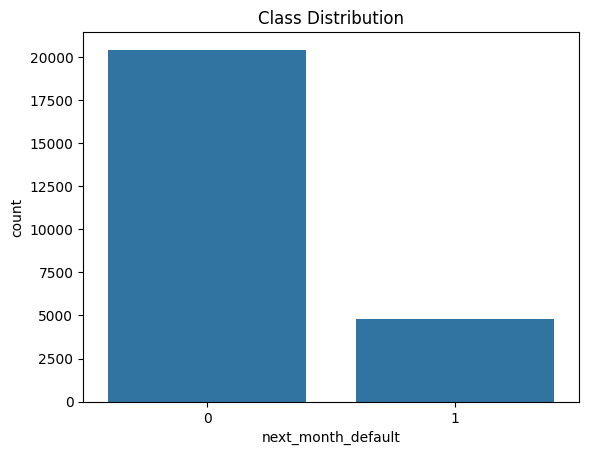

next_month_default
0    0.809601
1    0.190399
Name: proportion, dtype: float64


In [460]:
# Target variable distribution
sns.countplot(x='next_month_default', data=df)
plt.title("Class Distribution")
plt.show()

print(df['next_month_default'].value_counts(normalize=True))

# -> 20% of users are likely to default next month

Total rows in the dataset: 25247


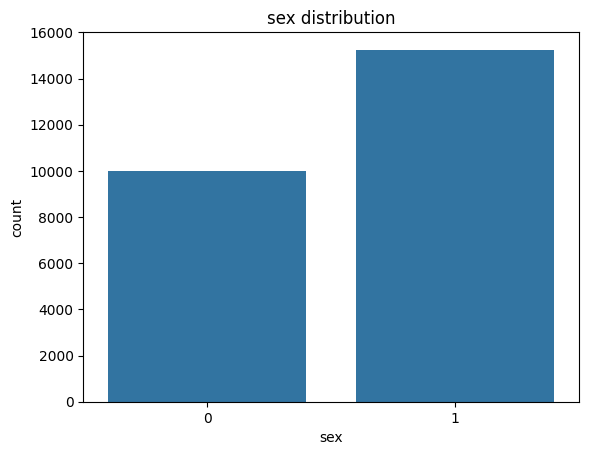

sex unique values: [0 1]
sex
1    60.411138
0    39.588862
Name: proportion, dtype: float64
sex
1    15252
0     9995
Name: count, dtype: int64


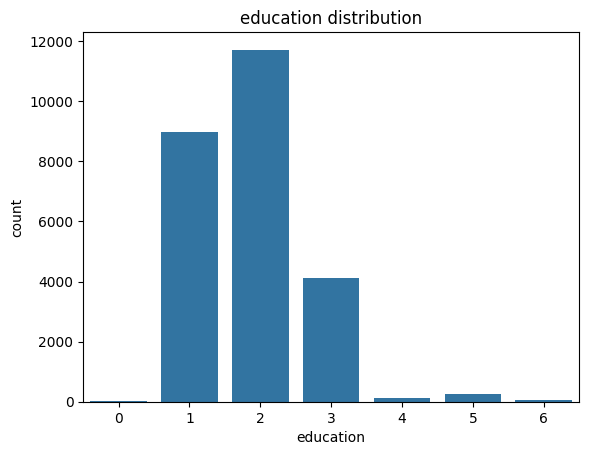

education unique values: [2 1 3 4 5 6 0]
education
2    46.409474
1    35.600269
3    16.298966
5     1.002099
4     0.459461
6     0.174278
0     0.055452
Name: proportion, dtype: float64
education
2    11717
1     8988
3     4115
5      253
4      116
6       44
0       14
Name: count, dtype: int64


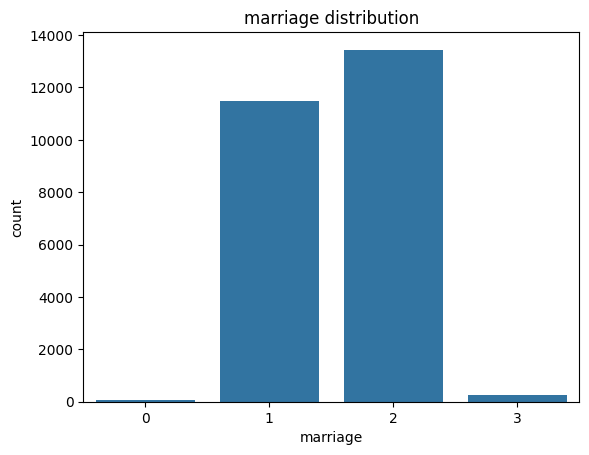

marriage unique values: [2 1 3 0]
marriage
2    53.238008
1    45.470749
3     1.081317
0     0.209926
Name: proportion, dtype: float64
marriage
2    13441
1    11480
3      273
0       53
Name: count, dtype: int64


In [461]:
categorical_cols = ['sex', 'education', 'marriage']

#print total rows in the dataset
print("Total rows in the dataset:", len(df))

for col in categorical_cols:
    sns.countplot(x=col, data=df)
    plt.title(f'{col} distribution')
    plt.show()
    print(f"{col} unique values:", df[col].unique())
    print(df[col].value_counts(normalize=True) * 100)
    print(df[col].value_counts())

# 297 outliers for education
# 273 outliers for marriage
# Very less married people in the dataset -> only 53 out of 25247

#In marriage replace 3+ with median of 0,1,2
df['marriage'] = df['marriage'].replace(0, 3)

#In edu replace 3+ with median of 0,1,2
df['education'] = df['education'].replace(0, 4)
df['education'] = df['education'].replace(5, 4)
df['education'] = df['education'].replace(6, 4)


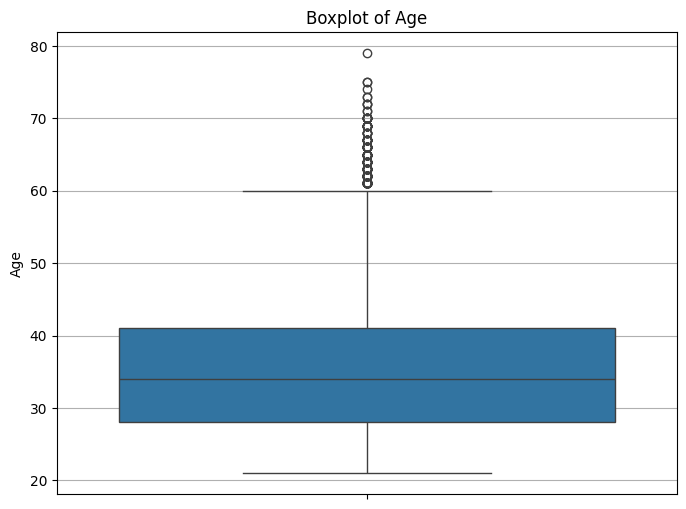

In [462]:
# Boxplot for age
plt.figure(figsize=(8, 6))

sns.boxplot(y='age', data=df)
plt.title('Boxplot of Age')
plt.ylabel('Age')
plt.grid(axis='y')
plt.show()


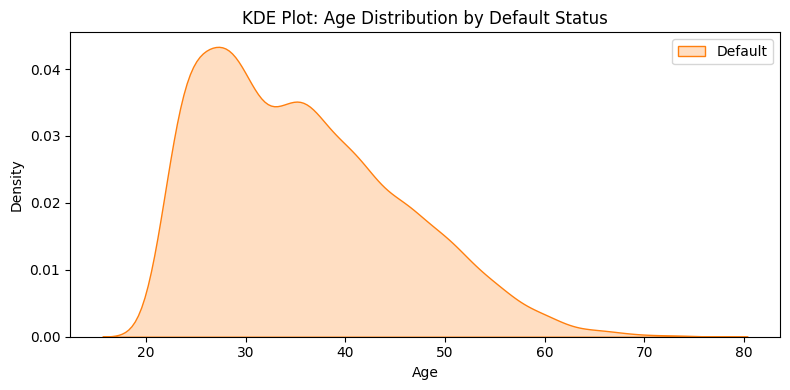

In [463]:

# KDE plot: Age distributions split by default status
plt.figure(figsize=(8, 4))

sns.kdeplot(
    data=df[df['next_month_default'] == 1],
    x='age',
    label='Default',
    fill=True,
    color="#ff7f0e"
)
plt.title("KDE Plot: Age Distribution by Default Status")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

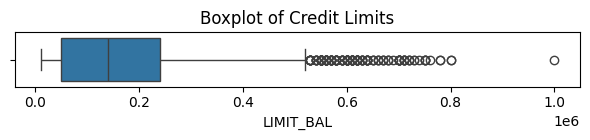

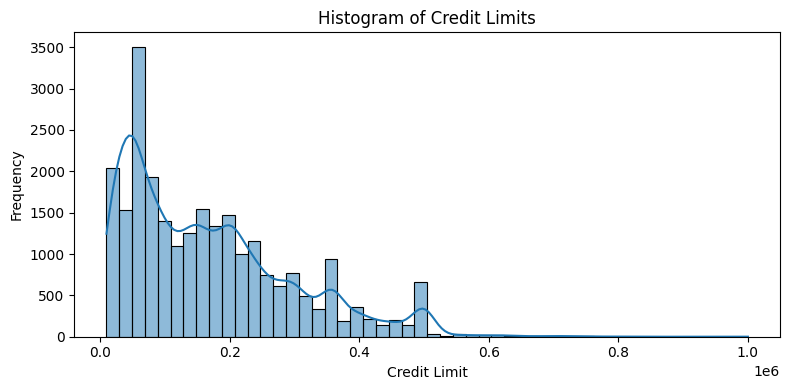

In [464]:
# EDA for Limit Balance
# 2. Boxplot of Credit Limit
plt.figure(figsize=(6, 1.5))
sns.boxplot(x=df['LIMIT_BAL'])
plt.title("Boxplot of Credit Limits")
plt.tight_layout()
plt.show()

#also print histogram
plt.figure(figsize=(8, 4))
sns.histplot(df['LIMIT_BAL'], bins=50, kde=True)
plt.title("Histogram of Credit Limits")
plt.xlabel("Credit Limit")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [465]:
# number of outliers in LIMIT_BAL

# Q1 = df['LIMIT_BAL'].quantile(0.25)
# Q3 = df['LIMIT_BAL'].quantile(0.75)
# IQR = Q3 - Q1

# # Capping the outliers to upper IQR bound
# lower_bound = max(Q1 - 1.5 * IQR,0)
# upper_bound = Q3 + 1.5 * IQR

# outliers = df[(df['LIMIT_BAL'] < lower_bound) | (df['LIMIT_BAL'] > upper_bound)]
# print(f'Lower bound: {lower_bound}, Upper bound: {upper_bound}')
# print(f'Number of outliers in LIMIT_BAL: {len(outliers)}')

# print(df.shape)
# df['LIMIT_BAL'] = df['LIMIT_BAL'].clip(lower=lower_bound, upper=upper_bound)
# # Print dimensions after cleaning
# print("Shape after capping LIMIT_BAL outliers:", df.shape)

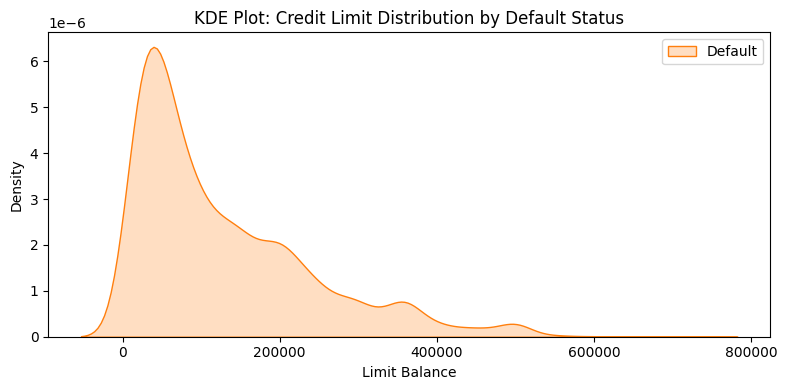

In [466]:
# kde plot for Limit Balance with default status

plt.figure(figsize=(8, 4))
sns.kdeplot(
    data=df[df['next_month_default'] == 1],
    x='LIMIT_BAL',
    label='Default',
    fill=True,
    color="#ff7f0e"
)
plt.title("KDE Plot: Credit Limit Distribution by Default Status")
plt.xlabel("Limit Balance")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

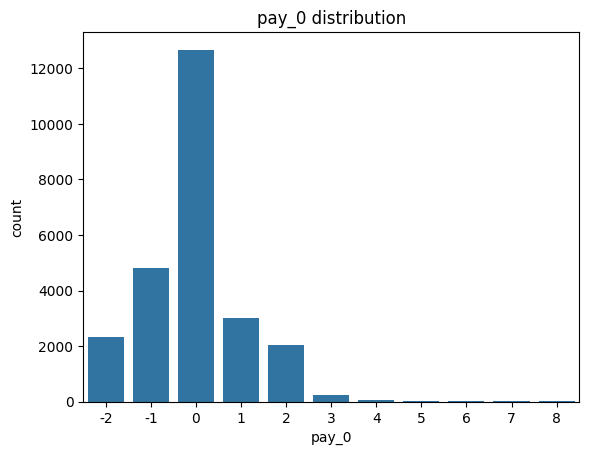

pay_0 unique values: [ 2  0 -2 -1  1  8  4  3  5  6  7]
pay_0 value counts:
 pay_0
 0    12667
-1     4821
 1     3030
-2     2331
 2     2047
 3      244
 4       56
 5       21
 8       14
 6        8
 7        8
Name: count, dtype: int64


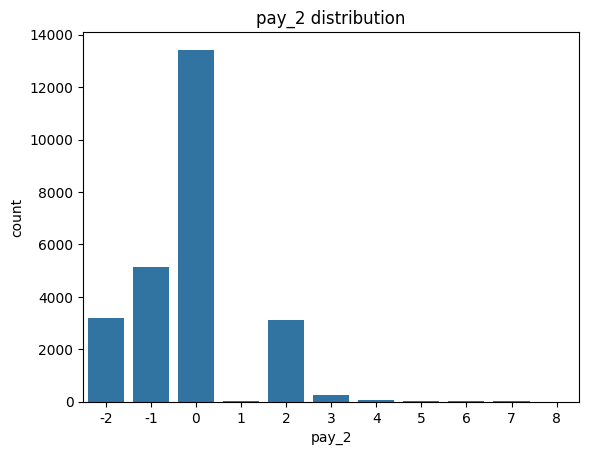

pay_2 unique values: [ 2  0 -2 -1  7  4  3  1  5  6  8]
pay_2 value counts:
 pay_2
 0    13424
-1     5128
-2     3210
 2     3098
 3      239
 4       77
 1       25
 5       19
 7       15
 6       11
 8        1
Name: count, dtype: int64


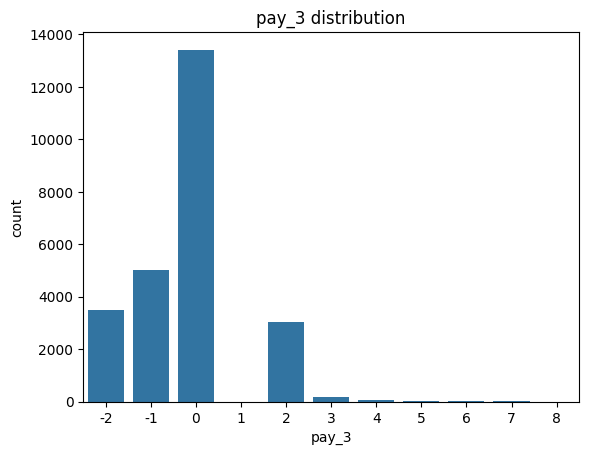

pay_3 unique values: [ 2 -2  0 -1  6  3  4  1  7  5  8]
pay_3 value counts:
 pay_3
 0    13415
-1     5019
-2     3480
 2     3039
 3      179
 4       57
 7       18
 5       18
 6       17
 1        4
 8        1
Name: count, dtype: int64


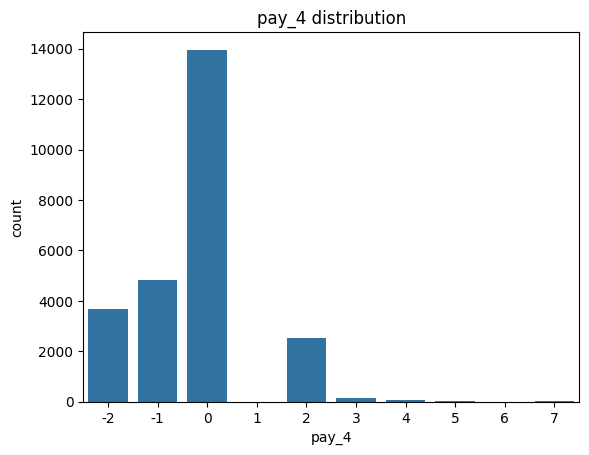

pay_4 unique values: [ 0 -2 -1  2  5  3  4  7  6  1]
pay_4 value counts:
 pay_4
 0    13961
-1     4816
-2     3694
 2     2509
 3      137
 4       52
 7       43
 5       29
 6        4
 1        2
Name: count, dtype: int64


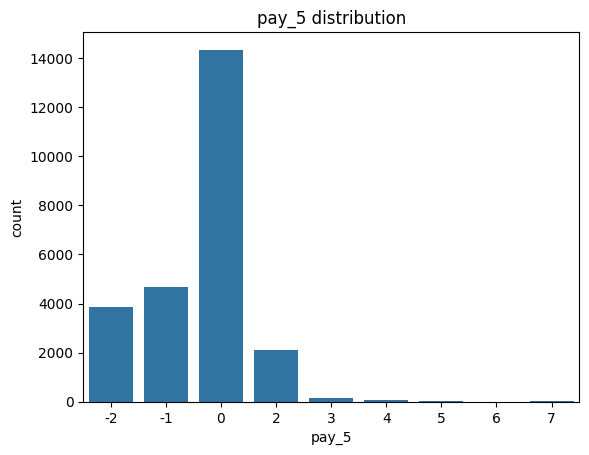

pay_5 unique values: [ 0 -1 -2  2  4  3  6  7  5]
pay_5 value counts:
 pay_5
 0    14345
-1     4680
-2     3859
 2     2100
 3      133
 4       72
 7       43
 5       14
 6        1
Name: count, dtype: int64


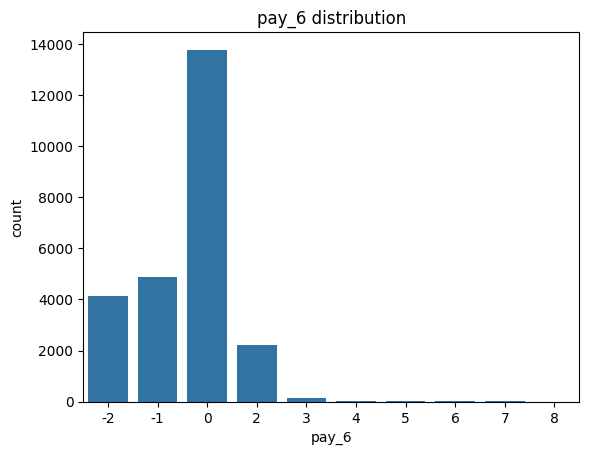

pay_6 unique values: [ 0 -2 -1  2  3  4  5  7  6  8]
pay_6 value counts:
 pay_6
 0    13769
-1     4882
-2     4139
 2     2223
 3      134
 4       41
 7       34
 6       14
 5       10
 8        1
Name: count, dtype: int64


In [467]:
pay_status_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

for col in pay_status_cols:
    sns.countplot(x=col, data=df)
    plt.title(f'{col} distribution')
    plt.show()
    print(f"{col} unique values:", df[col].unique())
    print(f"{col} value counts:\n", df[col].value_counts())
    

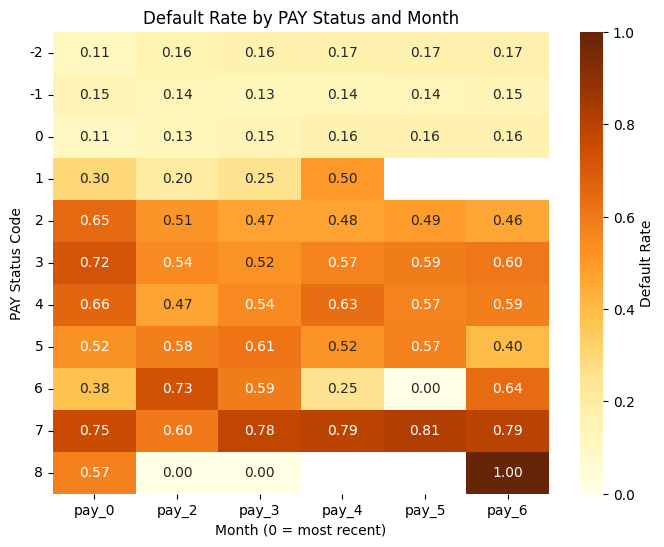

In [468]:
# 1) Melt your pay‐status columns into long form
# Use the correct column names as in your DataFrame
pay_status_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
df_long = (
    df
    .reset_index()                         # preserve original index as “customer_id” if you like
    .melt(id_vars=['next_month_default'], 
          value_vars=pay_status_cols,
          var_name='month',
          value_name='pay_status')
)

# Convert next_month_default to int for aggregation
df_long['next_month_default'] = df_long['next_month_default'].astype(int)

# 2) Compute default rate by (month, pay_status)
pivot = (
    df_long
    .groupby(['month','pay_status'])['next_month_default']
    .mean()
    .reset_index()
    .pivot(index='pay_status', columns='month', values='next_month_default')
)

# 3) Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlOrBr", cbar_kws={'label':'Default Rate'})
plt.title("Default Rate by PAY Status and Month")
plt.xlabel("Month (0 = most recent)")
plt.ylabel("PAY Status Code")
plt.yticks(rotation=0)
plt.show()

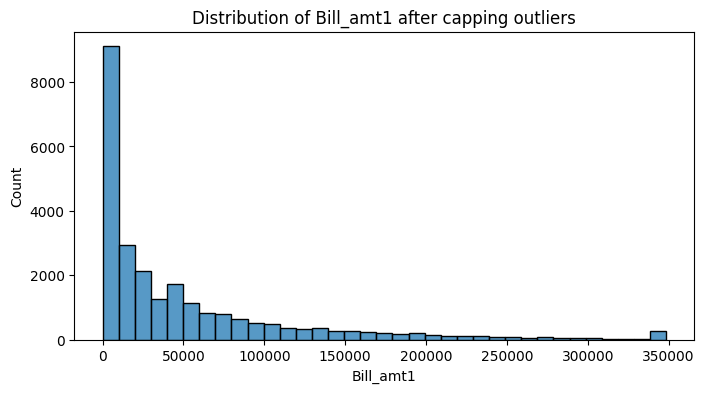

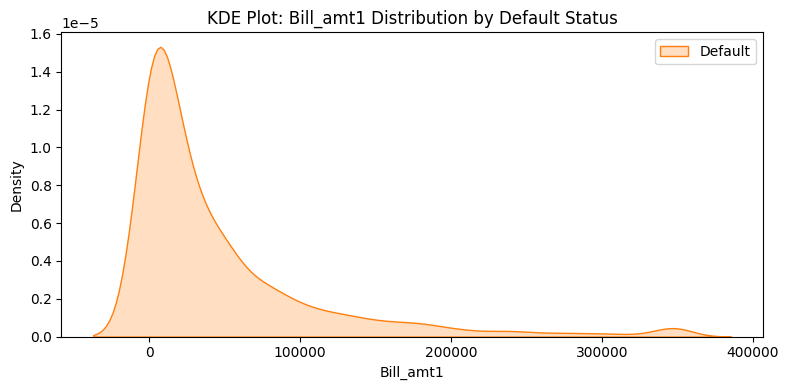

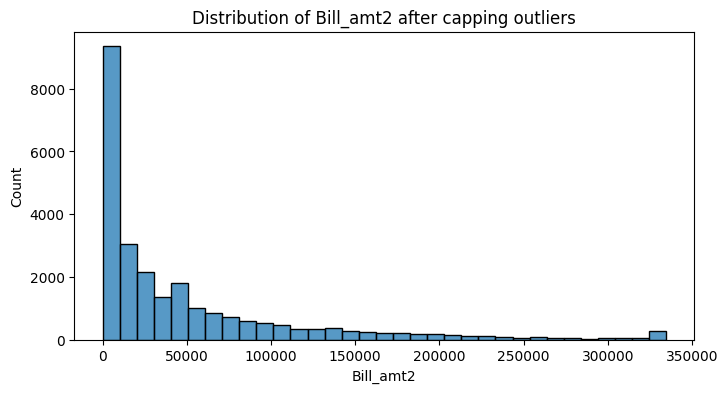

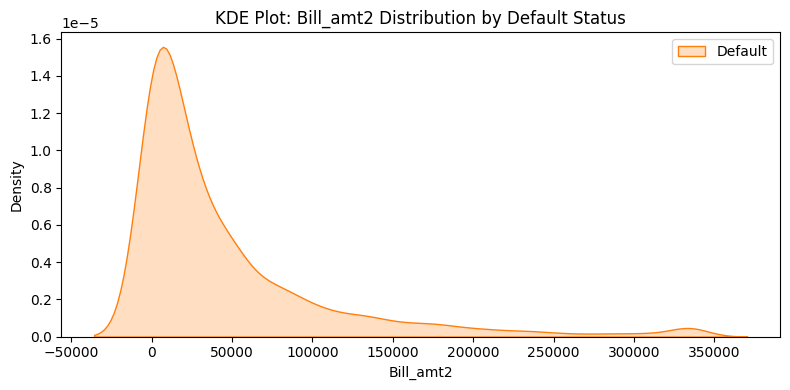

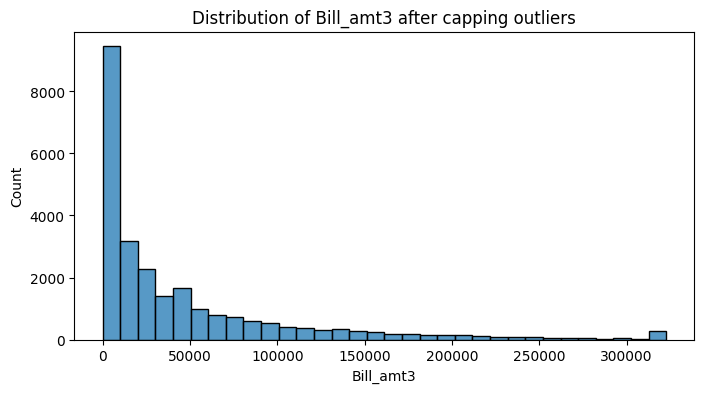

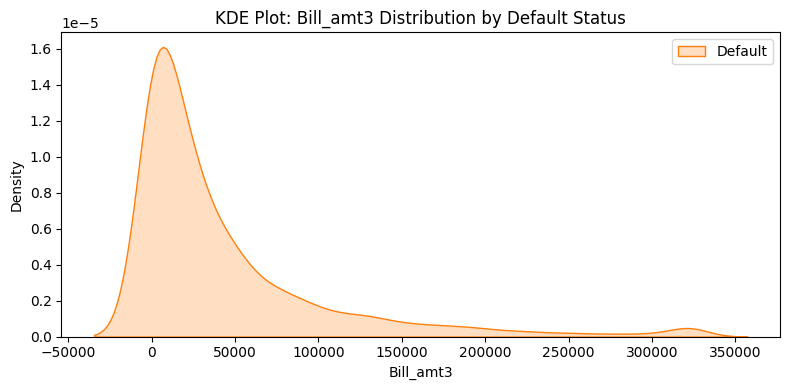

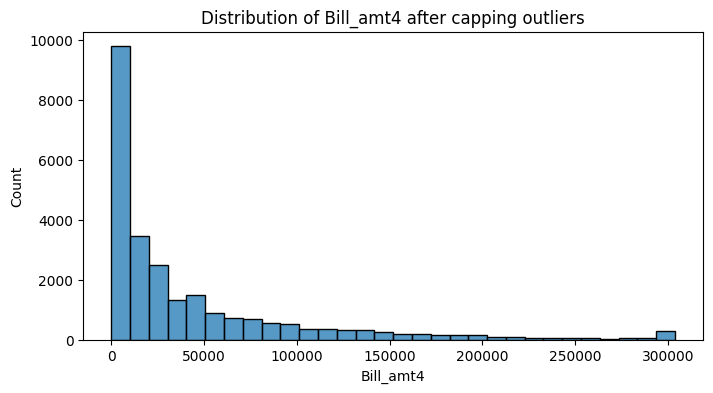

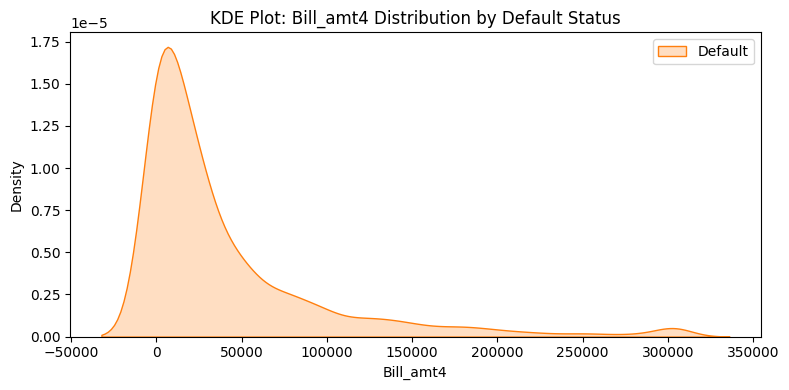

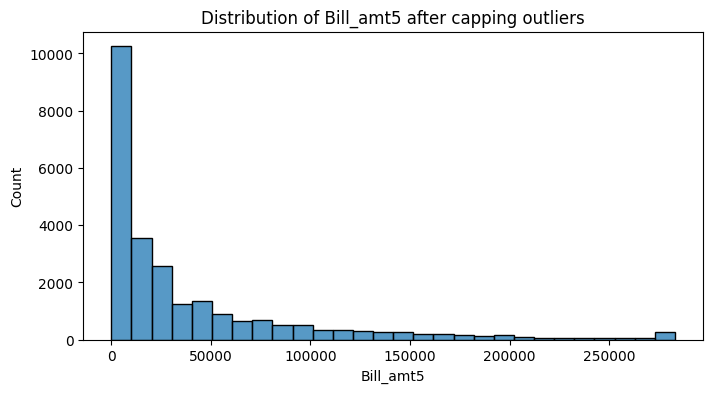

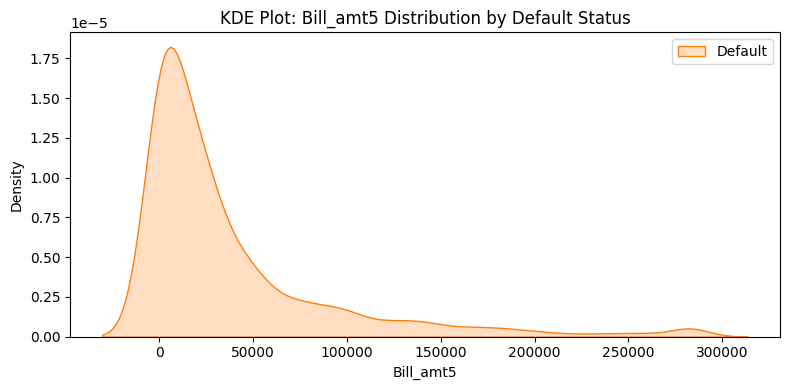

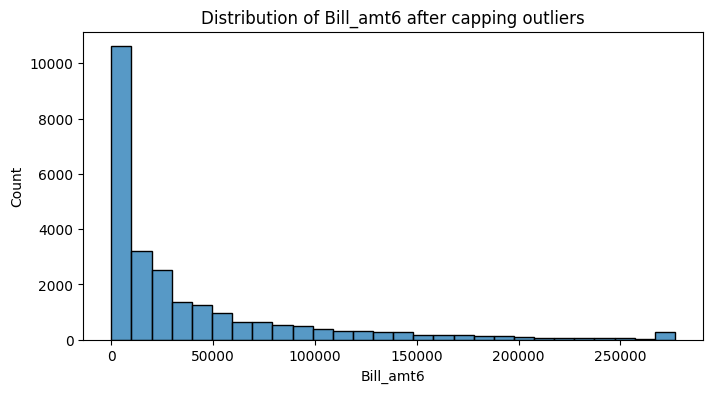

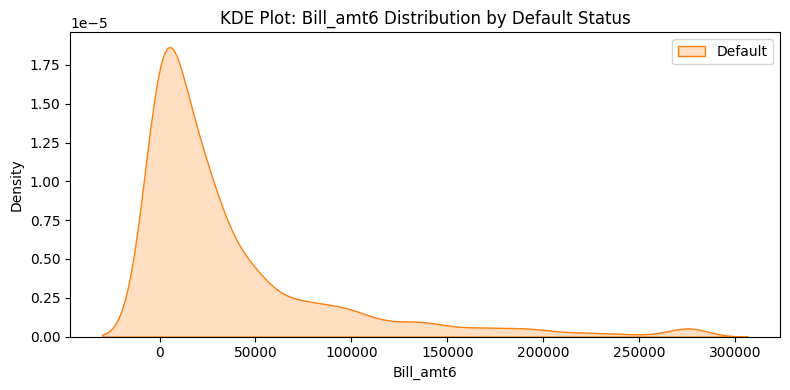

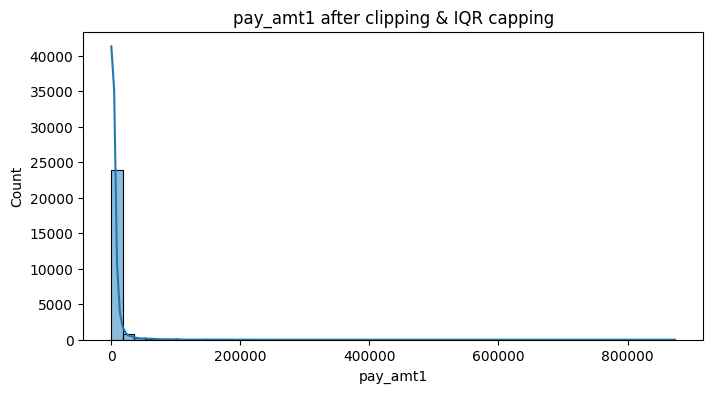

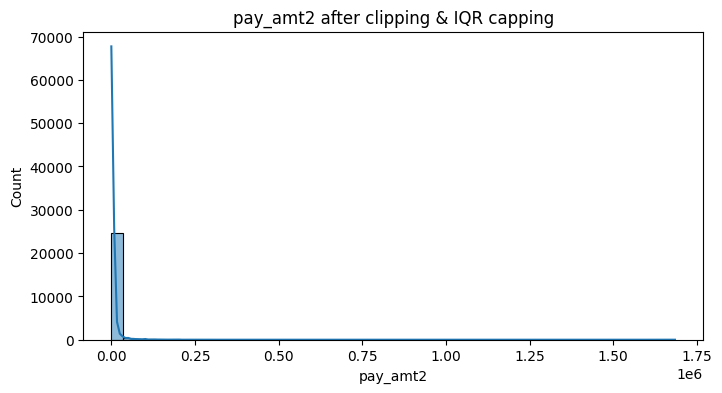

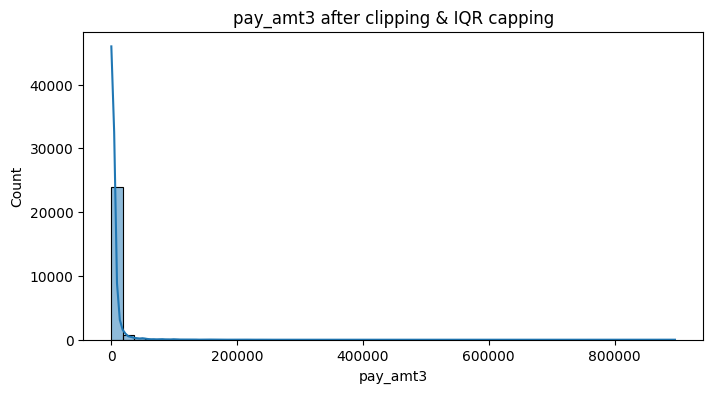

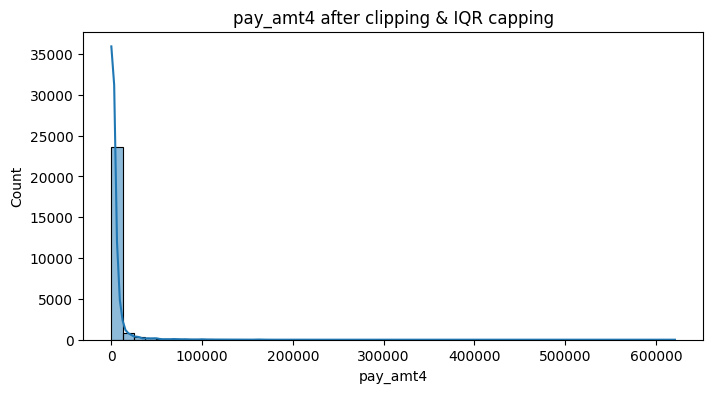

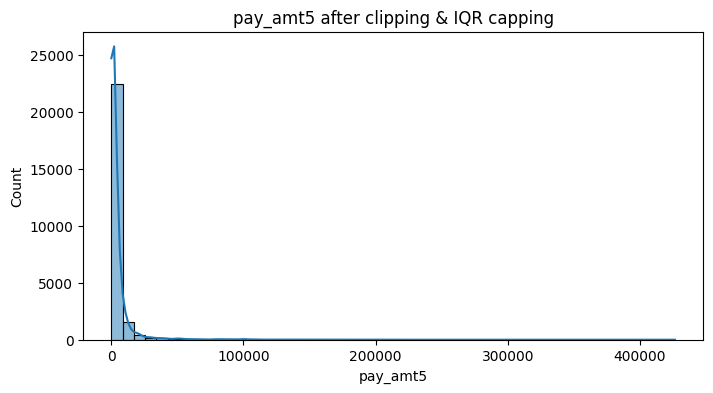

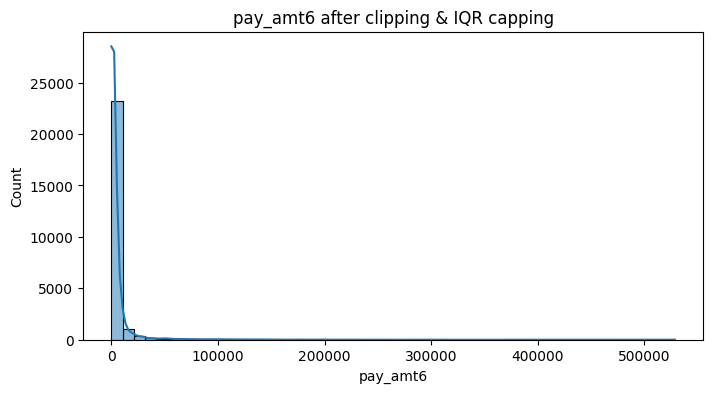

In [469]:

# print("Shape after dropping outliers:", df.shape)

bill_cols = [f'Bill_amt{i}' for i in range(1, 7)]

for col in bill_cols:
    df[col] = df[col].clip(lower=0)
    cap = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=0, upper=cap)
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], binwidth=10000)
    plt.title(f'Distribution of {col} after capping outliers')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# Check for negative values in bill columns after clipping
    # print("Negative values in bill columns after clipping:")
    # print(df[col].lt(0).sum())
# KDE plot for Bill Amounts with default status
    plt.figure(figsize=(8, 4))
    sns.kdeplot(
        data=df[df['next_month_default'] == 1],
        x=col,
        label='Default',
        fill=True,
        color="#ff7f0e"
    )
    plt.title(f"KDE Plot: {col} Distribution by Default Status")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


#similarly for pay amounts
pay_cols = [f'pay_amt{i}' for i in range(1, 7)]
for col in pay_cols:
    df[col] = df[col].clip(lower=0)

    # histogram with smaller bins
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"{col} after clipping & IQR capping")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


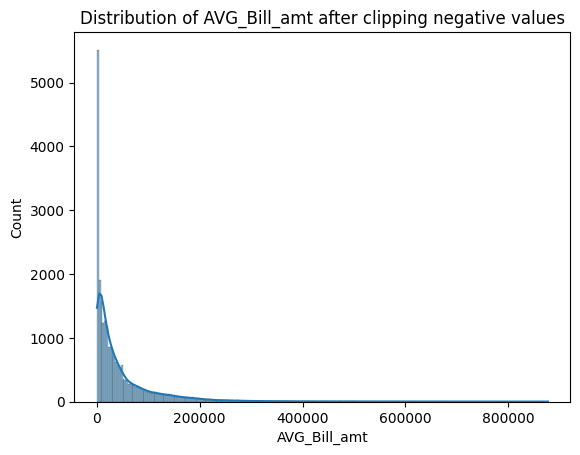

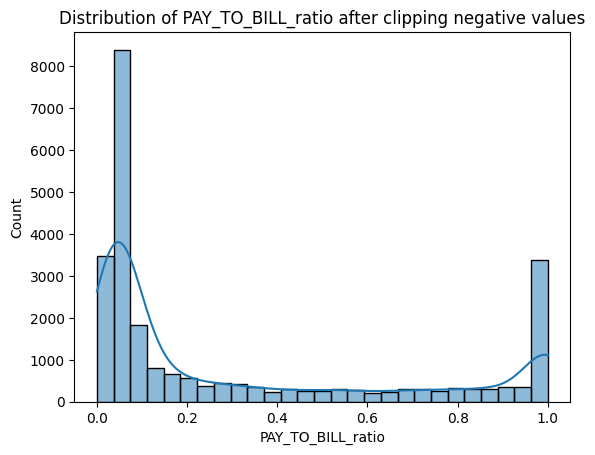

After capping, AVG_Bill_amt shape: (25247,)


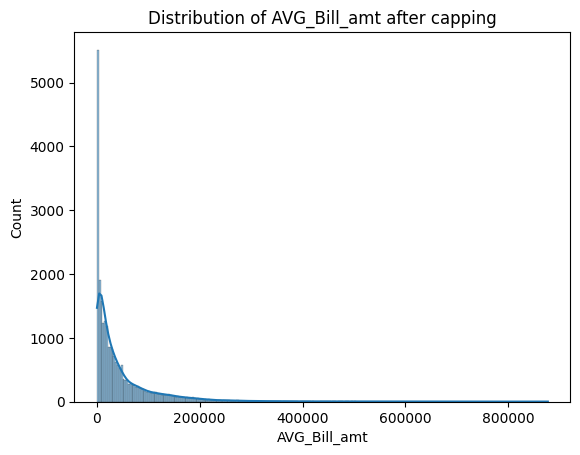

After capping, PAY_TO_BILL_ratio shape: (25247,)


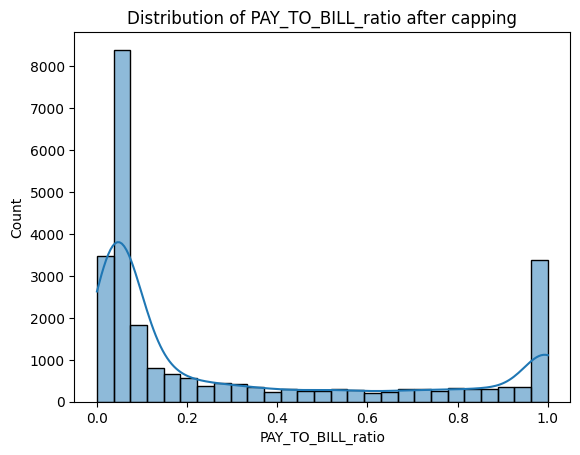

In [470]:
bill_cols = [f'Bill_amt{i}' for i in range(1, 7)]
pay_cols = [f'pay_amt{i}' for i in range(1, 7)]
eng_cols = ['AVG_Bill_amt', 'PAY_TO_BILL_ratio']

df['PAY_TO_BILL_ratio'] = df['PAY_TO_BILL_ratio'].clip(lower=0.0, upper=1.0)
df['AVG_Bill_amt'] = df['AVG_Bill_amt'].clip(lower=0.0)

# for col in ['LIMIT_BAL', 'AVG_Bill_amt'] + bill_cols + pay_cols:
#         # Add small constant to handle zeros
#         df[f'log_{col}'] = np.log1p(df[col])
# for col in eng_cols:
#     # lower = df[col].quantile(0.005)
#     # upper = df[col].quantile(0.975)
#     # df = df[(df[col] >= lower) & (df[col] <= upper)]
#     # df.reset_index(drop=True, inplace=True)
#     # print(f"After capping, {col} shape: {df[col].shape}")
#     # now plot
#     sns.histplot(df[col], kde=True)
#     plt.title(f'Distribution of {col} after capping')
#     plt.show()

# clip eng_cols to 0.005 and 0.975 quantiles
# for col in eng_cols:
#     lower = df[col].quantile(0.005)
#     upper = df[col].quantile(0.975)
#     df[col] = df[col].clip(lower=lower, upper=upper)
#     print(f"After capping, {col} shape: {df[col].shape}")
#     # now plot
#     sns.histplot(df[col], kde=True)
#     plt.title(f'Distribution of {col} after capping')
#     plt.show()


#make negative values in engineering columns to 0
for col in eng_cols:
    df[col] = df[col].clip(lower=0)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col} after clipping negative values')
    plt.show()

#apply log transformation to engineering columns
# for col in eng_cols:
#     if(col == 'PAY_TO_BILL_ratio'):
#         continue
#     df[col] = np.log1p(df[col])  # log1p handles zero values correctly
#     sns.histplot(df[col], kde=True)
#     plt.title(f'Distribution of {col} after log transformation')
#     plt.show()



# Clip the engineering columns to 0.005 and 0.975 quantiles
for col in eng_cols:
    lower = df[col].quantile(0.05)
    upper = df[col].quantile(0.95)
    #df[col] = df[col].clip(lower=lower, upper=upper)
    print(f"After capping, {col} shape: {df[col].shape}")
    # now plot
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col} after capping')
    plt.show()
    
# see later

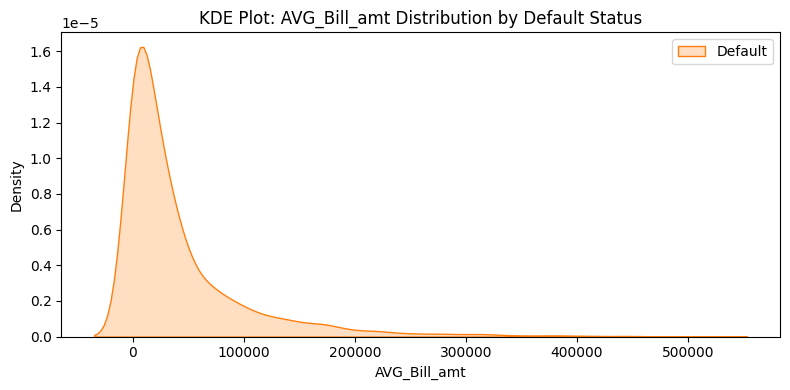

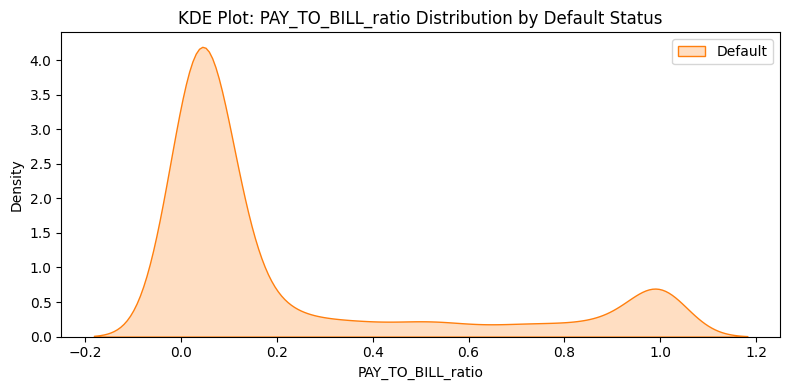

In [471]:
# relation between engineering columns and default status
# kde plot for AVG_Bill_amt (log transformed) with default status

plt.figure(figsize=(8, 4))
sns.kdeplot(
    data=df[df['next_month_default'] == 1],
    x='AVG_Bill_amt',
    label='Default',
    fill=True,
    color="#ff7f0e"
)


plt.title("KDE Plot: AVG_Bill_amt Distribution by Default Status")
plt.xlabel("AVG_Bill_amt")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()
# kde plot for PAY_TO_BILL_ratio with default status
plt.figure(figsize=(8, 4))
sns.kdeplot(
    data=df[df['next_month_default'] == 1],
    x='PAY_TO_BILL_ratio',
    label='Default',
    fill=True,
    color="#ff7f0e"
)





plt.title("KDE Plot: PAY_TO_BILL_ratio Distribution by Default Status")
plt.xlabel("PAY_TO_BILL_ratio")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()




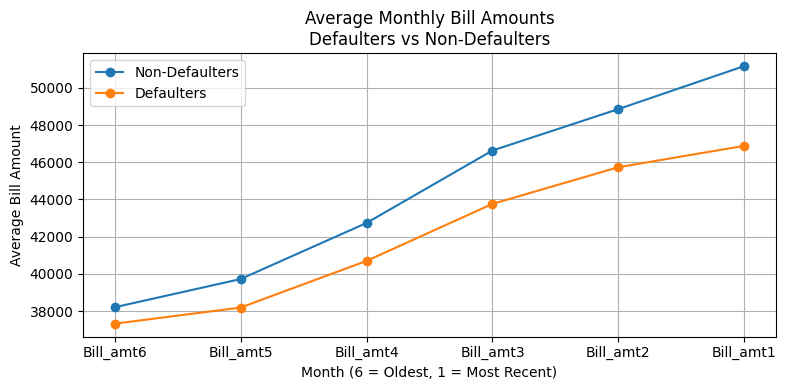

In [472]:
# EDA for Bill Amounts# Columns for monthly bill amounts
bill_cols = ['Bill_amt6', 'Bill_amt5', 'Bill_amt4', 'Bill_amt3', 'Bill_amt2', 'Bill_amt1']  # reversed for chronological order

# Group by default status
bill_means = df.groupby('next_month_default')[bill_cols].mean().T
bill_means.columns = ['Non-Defaulters', 'Defaulters'] if 0 in bill_means.columns else ['Defaulters', 'Non-Defaulters']

# Plot
bill_means.plot(figsize=(8, 4), marker='o')
plt.title("Average Monthly Bill Amounts\nDefaulters vs Non-Defaulters")
plt.xlabel("Month (6 = Oldest, 1 = Most Recent)")
plt.ylabel("Average Bill Amount")
plt.grid(True)
plt.tight_layout()
plt.show()

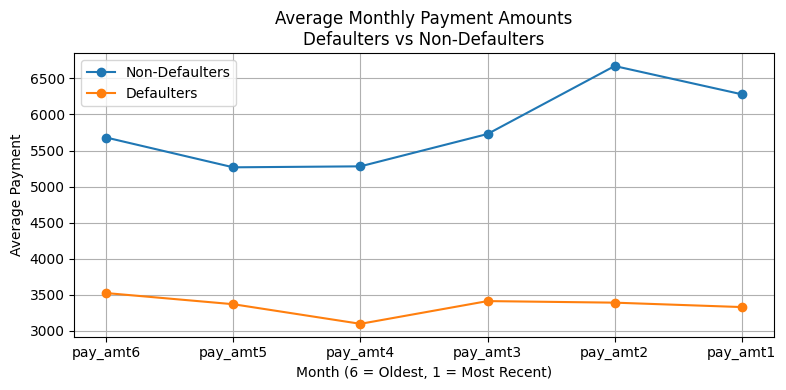

In [473]:
# Payment columns (chronologically reversed)
pay_cols_amt = ['pay_amt6', 'pay_amt5', 'pay_amt4', 'pay_amt3', 'pay_amt2', 'pay_amt1']

# Group by default status and calculate average
pay_means = df.groupby('next_month_default')[pay_cols_amt].mean().T
pay_means.columns = ['Non-Defaulters', 'Defaulters'] if 0 in pay_means.columns else ['Defaulters', 'Non-Defaulters']

# Plot
pay_means.plot(figsize=(8, 4), marker='o')
plt.title("Average Monthly Payment Amounts\nDefaulters vs Non-Defaulters")
plt.xlabel("Month (6 = Oldest, 1 = Most Recent)")
plt.ylabel("Average Payment")
plt.grid(True)
plt.tight_layout()
plt.show()

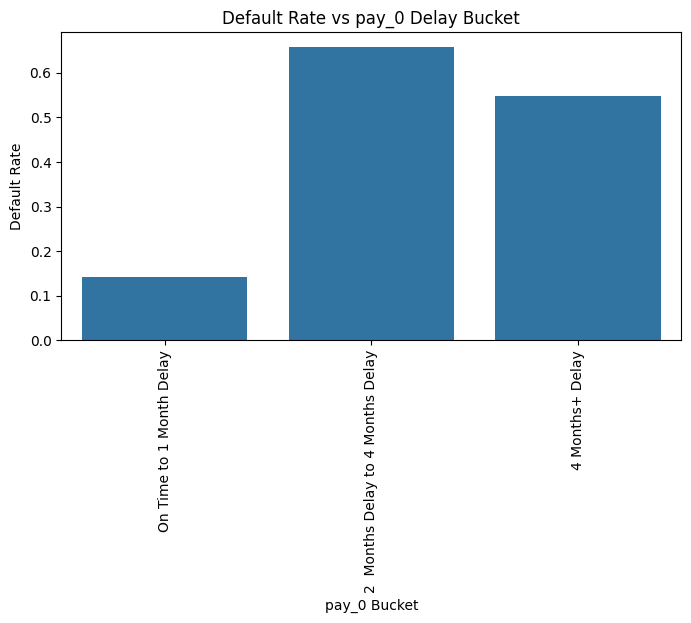

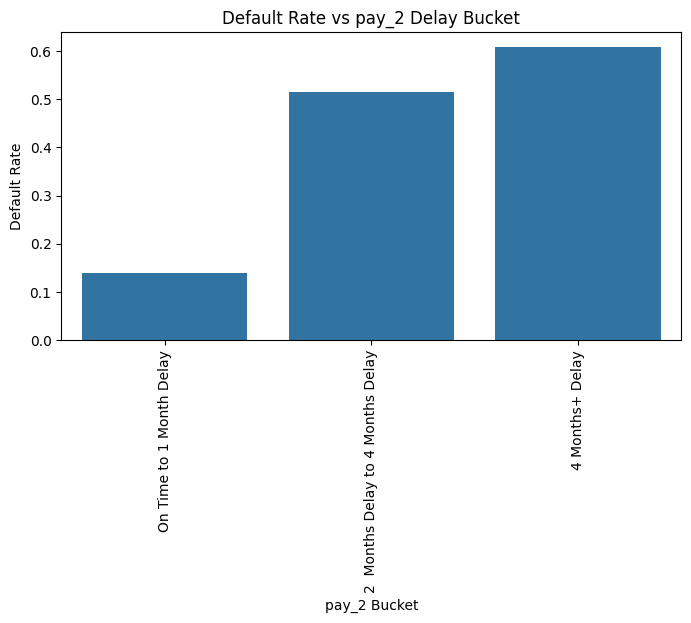

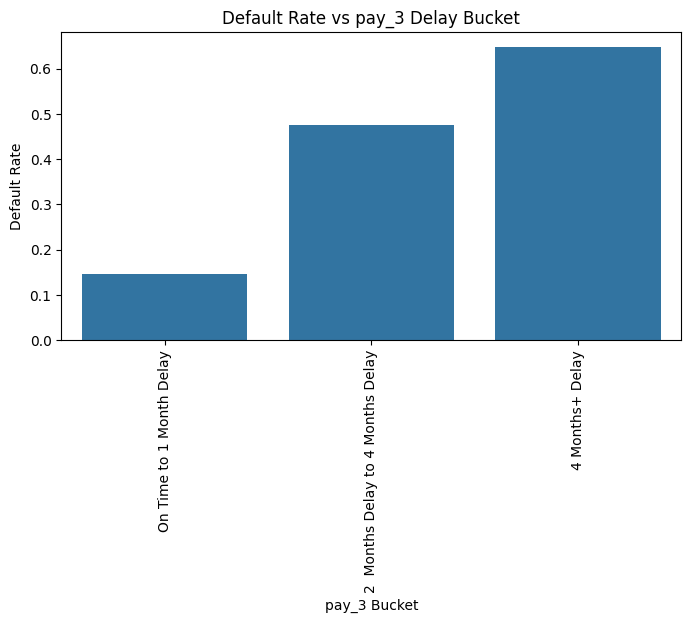

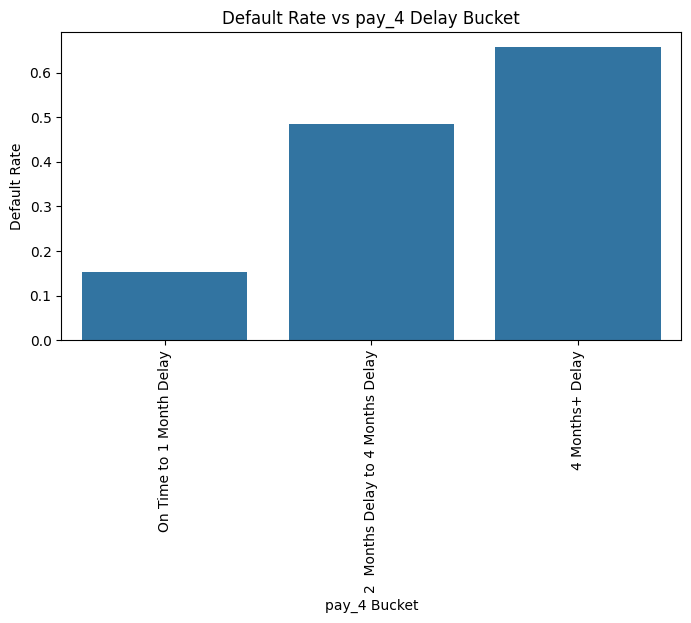

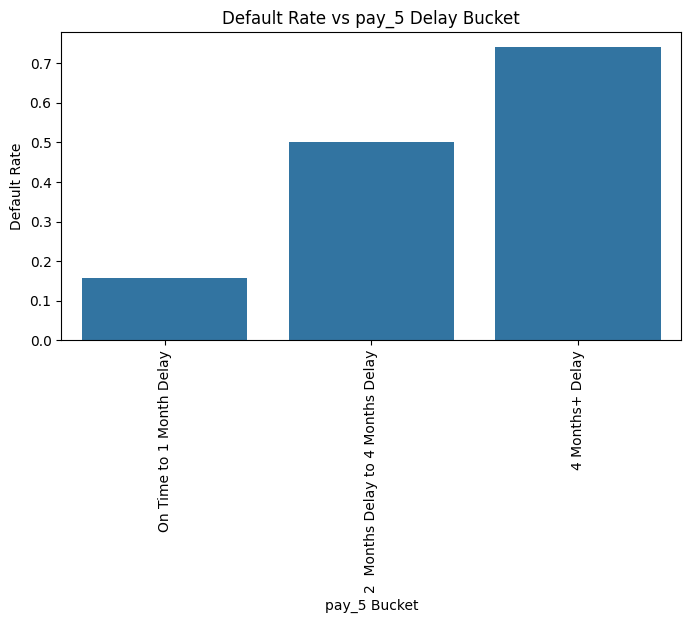

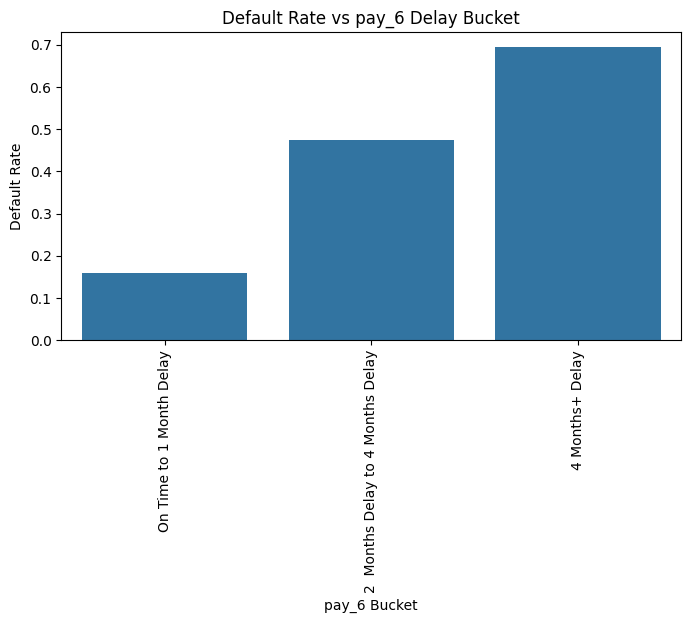

In [474]:
# Define delay_bucket function
def delay_bucket(x):
    if x <= 1:
        return 'On Time to 1 Month Delay'
    elif 2 <= x <= 4:
        return '2  Months Delay to 4 Months Delay'
    else:
        return '4 Months+ Delay'

#for pay_0 to pay_6, create buckets and plot default rate
for col in pay_status_cols[:]:
    df[f'{col}_bucket'] = df[col].apply(delay_bucket)
    grouped = df.groupby(f'{col}_bucket')['next_month_default'].agg(['mean', 'count']).reset_index()
    grouped.columns = [f'{col}_bucket', 'default_rate', 'count']
    
    plt.figure(figsize=(8, 4))
    sns.barplot(x=f'{col}_bucket', y='default_rate', data=grouped, order=[
        'On Time to 1 Month Delay', 
        '2  Months Delay to 4 Months Delay', 
        '4 Months+ Delay'
    ])
    plt.xticks(rotation=90)
    plt.title(f'Default Rate vs {col} Delay Bucket')
    plt.ylabel('Default Rate')
    plt.xlabel(f'{col} Bucket')
    plt.show()

C:\Users\krish\AppData\Local\Temp\ipykernel_144924\2224031925.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_limit = df.groupby('LIMIT_BAL_bucket')['next_month_default'].agg(['mean', 'count']).reset_index()


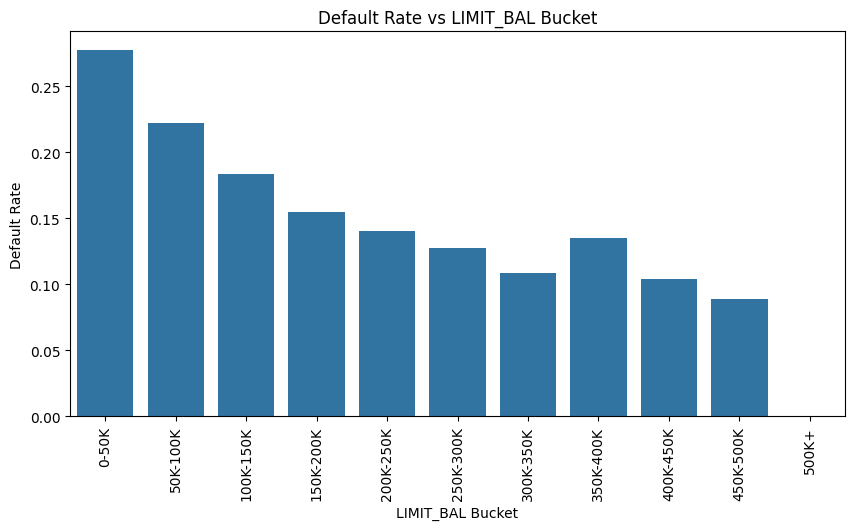

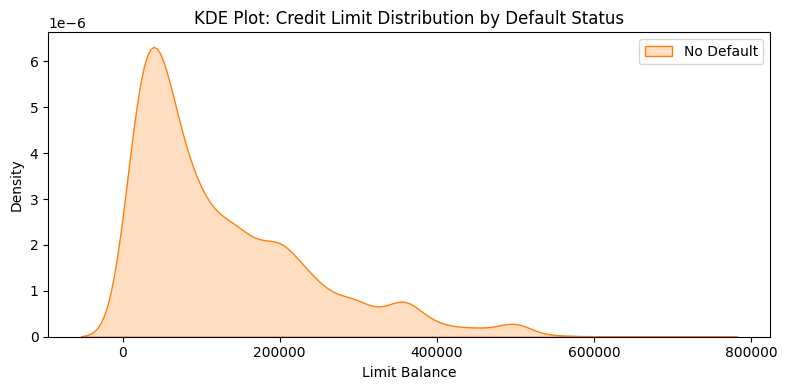

In [475]:
# Create LIMIT_BAL buckets
bins = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 5000000, np.inf]
labels = ['0-50K', '50K-100K', '100K-150K', '150K-200K', '200K-250K', '250K-300K', '300K-350K', '350K-400K', '400K-450K', '450K-500K', '500K+']

df['LIMIT_BAL_bucket'] = pd.cut(df['LIMIT_BAL'], bins=bins, labels=labels)

# Compute default rate for each LIMIT_BAL bucket
grouped_limit = df.groupby('LIMIT_BAL_bucket')['next_month_default'].agg(['mean', 'count']).reset_index()

grouped_limit.columns = ['LIMIT_BAL_bucket', 'default_rate', 'count']
# Plot default rate for LIMIT_BAL buckets
plt.figure(figsize=(10, 5))
sns.barplot(x='LIMIT_BAL_bucket', y='default_rate', data=grouped_limit)
plt.xticks(rotation=90)
plt.title('Default Rate vs LIMIT_BAL Bucket')
plt.ylabel('Default Rate')
plt.xlabel('LIMIT_BAL Bucket')
plt.show()


#also plot a continuous plot for LIMIT_BAL something like a kde plot
plt.figure(figsize=(8, 4))
sns.kdeplot(
    data=df[df['next_month_default'] == 1],
    x='LIMIT_BAL',
    label='No Default',
    fill=True,
    color="#ff7f0e"
)

plt.title("KDE Plot: Credit Limit Distribution by Default Status")
plt.xlabel("Limit Balance")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()




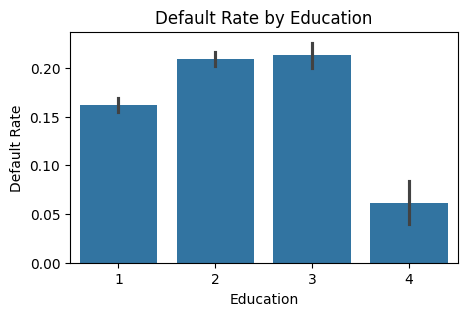

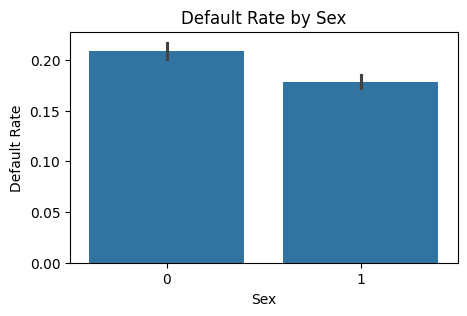

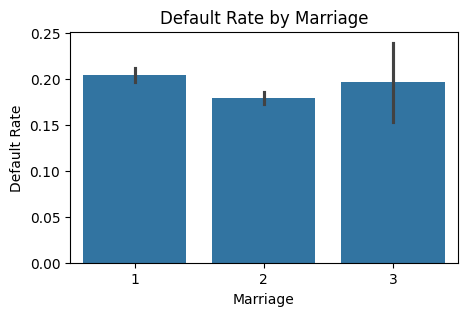

In [476]:
categorical_vars = ['education', 'sex', 'marriage']

for var in categorical_vars:
    plt.figure(figsize=(5, 3))
    sns.barplot(x=var, y='next_month_default', data=df)
    plt.title(f'Default Rate by {var.capitalize()}')
    plt.ylabel('Default Rate')
    plt.xlabel(var.capitalize())
    plt.show()


In [477]:

df.drop(columns=['Customer_ID'], inplace=True)


In [478]:
df['sex'] = df['sex'].astype('category')
df['education'] = df['education'].astype('category')
df['marriage'] = df['marriage'].astype('category')
df['next_month_default'] = df['next_month_default'].astype('category')


In [479]:

# drop 'pay_0_bucket', 'pay_2_bucket', 'pay_3_bucket', 'pay_4_bucket', 'pay_5_bucket', 'pay_6_bucket', 'LIMIT_BAL_bucket'
df.drop(columns=['pay_0_bucket', 'pay_2_bucket', 'pay_3_bucket', 'pay_4_bucket', 'pay_5_bucket', 'pay_6_bucket', 'LIMIT_BAL_bucket'], inplace=True)

#print dimensions of the dataset
print("Final dataset shape:", df.shape)

#print cols
print("Columns in the final dataset:")
print(df.columns.tolist())


Final dataset shape: (25247, 26)
Columns in the final dataset:
['marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'next_month_default']


In [480]:

df.head()

,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,2,0,2,60000,25.0,2,2,2,0,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,2,1,1,290000,24.0,0,0,-2,-2,-1,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,1,0,2,180000,63.0,0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,1,1,2,210000,43.0,0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,2,0,1,280000,32.0,-2,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


In [481]:
import numpy as np

# 1. UTILIZATION FEATURES
df['utilization'] = df[[f'Bill_amt{i}' for i in range(1, 7)]].sum(axis=1) / (6 * df['LIMIT_BAL'] + 1e-6)
df['recent_utilization'] = df['Bill_amt1'] / (df['LIMIT_BAL'] + 1e-6)

# 2. PAYMENT TO BILL RATIOS
df['avg_pay_ratio'] = df[[f'pay_amt{i}' for i in range(1, 7)]].sum(axis=1) / (df[[f'Bill_amt{i}' for i in range(1, 7)]].sum(axis=1) + 1e-6)
df['recent_payment_ratio'] = df['pay_amt1'] / (df['Bill_amt1'] + 1e-6)

# 3. BILL AND PAYMENT STATS
df['bill_mean'] = df[[f'Bill_amt{i}' for i in range(1, 7)]].mean(axis=1)
df['bill_std'] = df[[f'Bill_amt{i}' for i in range(1, 7)]].std(axis=1)
df['pay_mean'] = df[[f'pay_amt{i}' for i in range(1, 7)]].mean(axis=1)
df['pay_std'] = df[[f'pay_amt{i}' for i in range(1, 7)]].std(axis=1)

# 4. DELINQUENCY STREAKS & PATTERNS
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
df['overdue_count'] = (df[pay_cols] >= 1).sum(axis=1)
df['on_time_count'] = (df[pay_cols] == -1).sum(axis=1)
df['avg_delinquency'] = df[pay_cols].replace([-2, -1], 0).mean(axis=1)
df['recent_delinquency'] = df['pay_0'].apply(lambda x: max(x, 0))

# Max consecutive months of delay
def max_consec(arr):
    max_run = run = 0
    for x in arr:
        if x >= 1:
            run += 1
            max_run = max(max_run, run)
        else:
            run = 0
    return max_run
df['max_overdue_streak'] = df[pay_cols].apply(lambda row: max_consec(row.values), axis=1)

# Months since last overdue
def last_overdue(row):
    for i, x in enumerate(row):
        if x >= 1:
            return i  # 0 = most recent
    return len(row)
df['months_since_overdue'] = df[pay_cols].apply(lambda r: last_overdue(r.values), axis=1)

# 5. PAYMENT CONSISTENCY
df['repayment_consistency'] = df[[f'pay_amt{i}' for i in range(1, 7)]].apply(lambda row: (row > 0).sum(), axis=1) / 6

# 6. SHORTFALL & BEHAVIOR RATIOS
df['shortfall_count'] = sum(df[f'pay_amt{i}'] < df[f'Bill_amt{i}'] for i in range(1, 7))
df['rev_to_ontime'] = (df[pay_cols] == 0).sum(axis=1) / ((df[pay_cols] == -1).sum(axis=1) + 1e-6)
df['rev_to_ontime'].fillna(0, inplace=True)



C:\Users\krish\AppData\Local\Temp\ipykernel_144924\2589461834.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rev_to_ontime'].fillna(0, inplace=True)


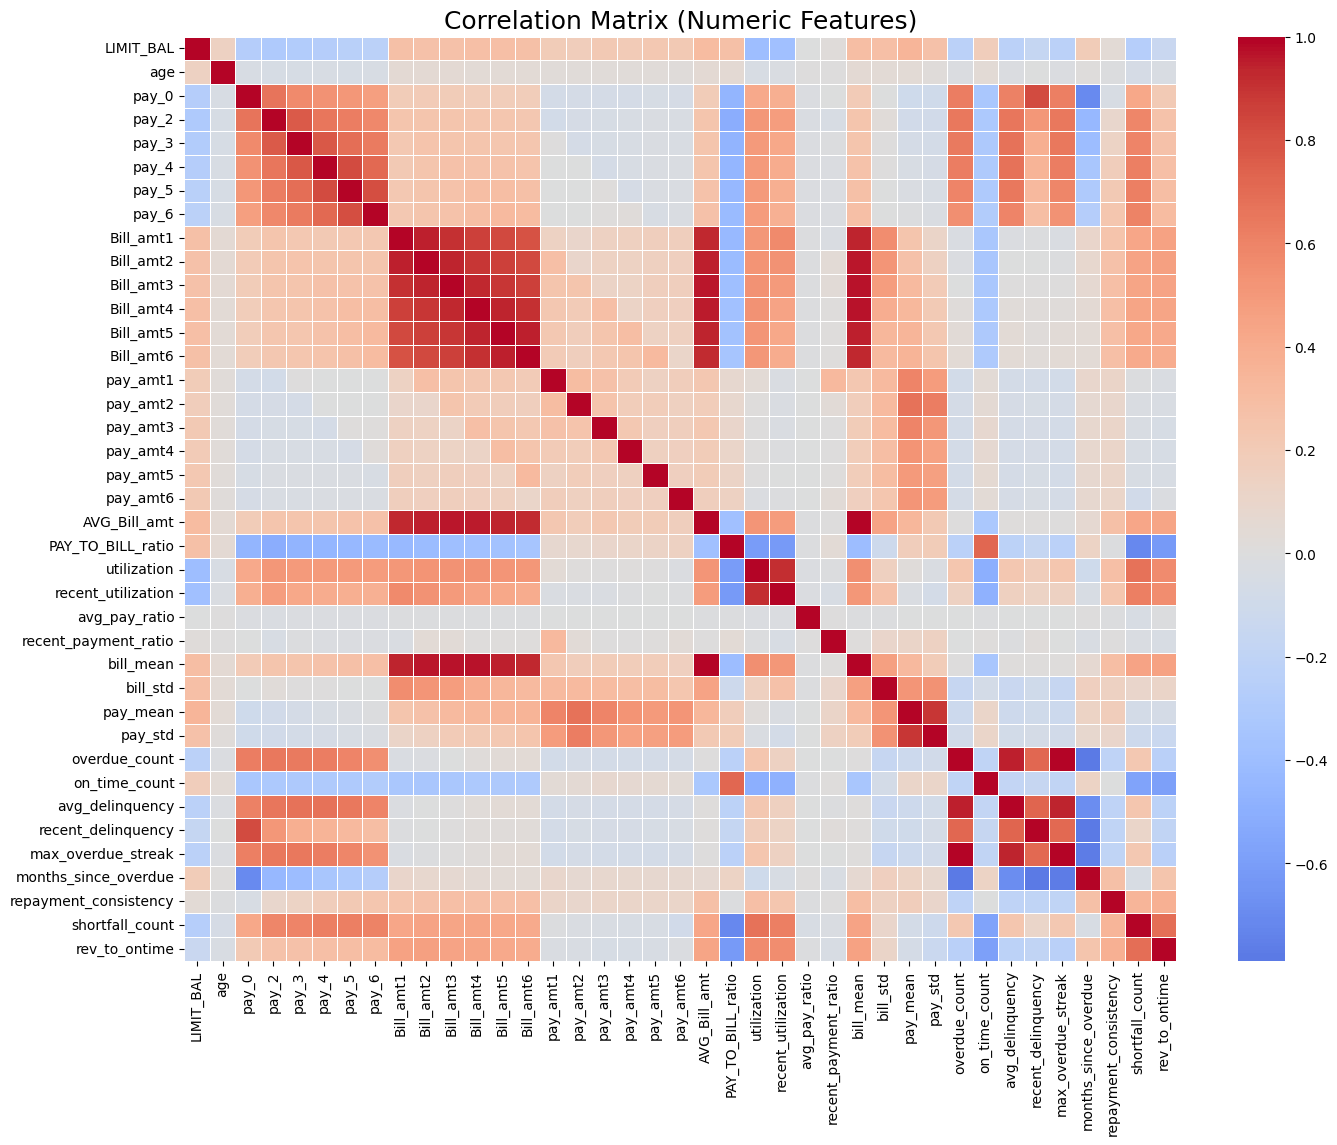

In [482]:
# plot overall correlation matrix
numeric_df = df.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix (Numeric Features)', fontsize=18)
plt.show()

In [483]:
selected_features = [
    'age', 'education', 'marriage', 'sex',
    'utilization', 'recent_utilization', 'avg_pay_ratio', 'recent_payment_ratio',
    'bill_mean', 'bill_std',  'pay_std','pay_mean',
    'overdue_count', 'on_time_count', 'avg_delinquency', 'recent_delinquency',
    'max_overdue_streak', 'months_since_overdue', 'repayment_consistency',
    'shortfall_count', 'rev_to_ontime', 
    'LIMIT_BAL', 
    'AVG_Bill_amt',	'PAY_TO_BILL_ratio'
]

X = df[selected_features]
y = df['next_month_default']


In [484]:
#check for NaN values in X
print("NaN values in X:")
print(X.isnull().sum())
#check for NaN values in y
print("NaN values in y:")
print(y.isnull().sum())

NaN values in X:
age                      0
education                0
marriage                 0
sex                      0
utilization              0
recent_utilization       0
avg_pay_ratio            0
recent_payment_ratio     0
bill_mean                0
bill_std                 0
pay_std                  0
pay_mean                 0
overdue_count            0
on_time_count            0
avg_delinquency          0
recent_delinquency       0
max_overdue_streak       0
months_since_overdue     0
repayment_consistency    0
shortfall_count          0
rev_to_ontime            0
LIMIT_BAL                0
AVG_Bill_amt             0
PAY_TO_BILL_ratio        0
dtype: int64
NaN values in y:
0


In [486]:
# # Step 2: Stratified Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)



In [487]:
#print types of each column in X_train
print("Column types in X_train:")
print(X_train.dtypes)

#convert categorical columns to int
for col in X_train.select_dtypes(include=['category']).columns:
    X_train[col] = X_train[col].cat.codes
    X_test[col] = X_test[col].cat.codes

# Print the updated types after conversion
print("Updated column types in X_train after conversion:")
print(X_train.dtypes)


#check for NaN values in X_train and X_test
print("NaN values in X_train:")
print(X_train.isnull().sum())
print("NaN values in X_test:")
print(X_test.isnull().sum())

Column types in X_train:
age                       float64
education                category
marriage                 category
sex                      category
utilization               float64
recent_utilization        float64
avg_pay_ratio             float64
recent_payment_ratio      float64
bill_mean                 float64
bill_std                  float64
pay_std                   float64
pay_mean                  float64
overdue_count               int64
on_time_count               int64
avg_delinquency           float64
recent_delinquency          int64
max_overdue_streak          int64
months_since_overdue        int64
repayment_consistency     float64
shortfall_count             int64
rev_to_ontime             float64
LIMIT_BAL                   int64
AVG_Bill_amt              float64
PAY_TO_BILL_ratio         float64
dtype: object
Updated column types in X_train after conversion:
age                      float64
education                   int8
marriage                    i

In [488]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, roc_auc_score
from imblearn.combine import SMOTETomek
import numpy as np
import pandas as pd

# --- Resample with SMOTETomek ---
smk = SMOTETomek(random_state=42)
X_train_res, y_train_res = smk.fit_resample(X_train, y_train)


# Convert resampled data to DataFrame (optional: use original column names)
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns if hasattr(X_train, 'columns') else None)
X_test = pd.DataFrame(X_test, columns=X_test.columns if hasattr(X_test, 'columns') else None)

# Convert all columns to numeric float32, filling any NaNs with 0
X_train_res = X_train_res.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)

# Make sure target variables are 1D numpy arrays
if isinstance(y_train_res, pd.DataFrame):
    y_train_res = y_train_res.iloc[:, 0]
y_train_res = np.array(y_train_res).ravel()

if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0]
y_test = np.array(y_test).ravel()


# --- Class Imbalance Weight for XGBoost ---
pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# --- Model Definitions ---
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
rf = RandomForestClassifier(class_weight='balanced', n_estimators=200, max_depth=10, random_state=42)
xgb = XGBClassifier(scale_pos_weight=pos_weight, use_label_encoder=False, eval_metric='logloss', random_state=42)

models = {
    'Logistic Regression': logreg,
    'Random Forest': rf,
    'XGBoost': xgb
}

# --- Evaluation Function ---
def evaluate_model(name, model):
    model.fit(X_train_res, y_train_res)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Find best threshold for F2-score
    thresholds = np.arange(0.1, 0.9, 0.01)
    f2_scores = [fbeta_score(y_test, y_proba >= t, beta=2) for t in thresholds]
    best_thresh = thresholds[np.argmax(f2_scores)]

    y_pred = (y_proba >= best_thresh).astype(int)

    print(f"\n{name} — Best Threshold for F2: {best_thresh:.2f}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-score:", fbeta_score(y_test, y_pred, beta=1))
    print("F2-score:", fbeta_score(y_test, y_pred, beta=2))
    print("AUC-ROC:", roc_auc_score(y_test, y_proba))

    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': fbeta_score(y_test, y_pred, beta=1),
        'F2-score': fbeta_score(y_test, y_pred, beta=2),
        'AUC-ROC': roc_auc_score(y_test, y_proba)
    }

# --- Train and Evaluate Models ---
results = []
for name, model in models.items():
    results.append(evaluate_model(name, model))

# --- Display Results ---
results_df = pd.DataFrame(results).set_index('Model')
results_df = results_df.sort_values('F2-score', ascending=False)
print("\nFinal Model Comparison:\n")
print(results_df)


C:\Users\krish\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression — Best Threshold for F2: 0.38
Accuracy: 0.4073927392739274
Precision: 0.23021073136178502
Recall: 0.9015256588072122
F1-score: 0.3667654112004514
F2-score: 0.5694261936049059
AUC-ROC: 0.6787686857189896

Random Forest — Best Threshold for F2: 0.23
Accuracy: 0.5776897689768977
Precision: 0.2887713392642462
Recall: 0.8328710124826629
F1-score: 0.4288519907159436
F2-score: 0.6049158859675632
AUC-ROC: 0.7798041472283477


C:\Users\krish\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [00:35:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost — Best Threshold for F2: 0.27
Accuracy: 0.5852145214521453
Precision: 0.28448275862068967
Recall: 0.7780859916782247
F1-score: 0.41663572224285184
F2-score: 0.5776359143327842
AUC-ROC: 0.7457614306813847

Final Model Comparison:

                     Accuracy  Precision    Recall  F1-score  F2-score  \
Model                                                                    
Random Forest        0.577690   0.288771  0.832871  0.428852  0.604916   
XGBoost              0.585215   0.284483  0.778086  0.416636  0.577636   
Logistic Regression  0.407393   0.230211  0.901526  0.366765  0.569426   

                      AUC-ROC  
Model                          
Random Forest        0.779804  
XGBoost              0.745761  
Logistic Regression  0.678769  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score

# Step 1: Retrain RF on full resampled data
best_rf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=200,
    max_depth=10,
    random_state=42
)
best_rf.fit(X_train_res, y_train_res)

# Step 2: Predict on X_test
y_proba_test = best_rf.predict_proba(X_test)[:, 1]

# Step 3: Evaluate thresholds and capture results
thresholds = np.arange(0.1, 0.9, 0.01)
records = []
for t in thresholds:
    preds = (y_proba_test >= t).astype(int)
    f2 = fbeta_score(y_test, preds, beta=2, zero_division=0)
    positives = preds.sum()
    records.append((t, f2, positives))
    # Debug print per iteration
    print(f"Threshold {t:.2f} — F2: {f2:.4f}, PredictedPositives: {positives}")

# Step 4: Build DataFrame
results_df = pd.DataFrame(records, columns=['Threshold', 'F2-Score', 'Predicted_1s'])

# Show only top and bottom, then full if small
print("\nTop 5 thresholds by F2 score:")
print(results_df.nlargest(5, 'F2-Score').to_string(index=False))

print("\nFull threshold table:")
print(results_df.to_string(index=False))

# Step 5: Display best threshold summary
best_row = results_df.loc[results_df['F2-Score'].idxmax()]
print("\n🏆 Best threshold for F2:")
print(best_row.to_frame().T.to_string(index=False))



Threshold 0.10 — F2: 0.5631, PredictedPositives: 6788
Threshold 0.11 — F2: 0.5681, PredictedPositives: 6597
Threshold 0.12 — F2: 0.5698, PredictedPositives: 6377
Threshold 0.13 — F2: 0.5725, PredictedPositives: 6180
Threshold 0.14 — F2: 0.5784, PredictedPositives: 5997
Threshold 0.15 — F2: 0.5824, PredictedPositives: 5797
Threshold 0.16 — F2: 0.5876, PredictedPositives: 5583
Threshold 0.17 — F2: 0.5892, PredictedPositives: 5374
Threshold 0.18 — F2: 0.5921, PredictedPositives: 5143
Threshold 0.19 — F2: 0.5953, PredictedPositives: 4940
Threshold 0.20 — F2: 0.5977, PredictedPositives: 4747
Threshold 0.21 — F2: 0.5996, PredictedPositives: 4556
Threshold 0.22 — F2: 0.6042, PredictedPositives: 4336
Threshold 0.23 — F2: 0.6049, PredictedPositives: 4159
Threshold 0.24 — F2: 0.6023, PredictedPositives: 4003
Threshold 0.25 — F2: 0.6043, PredictedPositives: 3821
Threshold 0.26 — F2: 0.6007, PredictedPositives: 3671
Threshold 0.27 — F2: 0.5986, PredictedPositives: 3537
Threshold 0.28 — F2: 0.6003,

In [493]:
# --- Step 1: Load validation dataset ---
validate_df = pd.read_csv("validate_dataset_final.csv")

# --- Step 2: Preprocess validation dataset ---
# Feature engineering to match training data

# 1. UTILIZATION FEATURES
validate_df['utilization'] = validate_df[[f'Bill_amt{i}' for i in range(1, 7)]].sum(axis=1) / (6 * validate_df['LIMIT_BAL'] + 1e-6)
validate_df['recent_utilization'] = validate_df['Bill_amt1'] / (validate_df['LIMIT_BAL'] + 1e-6)

# 2. PAYMENT TO BILL RATIOS
validate_df['avg_pay_ratio'] = validate_df[[f'pay_amt{i}' for i in range(1, 7)]].sum(axis=1) / (validate_df[[f'Bill_amt{i}' for i in range(1, 7)]].sum(axis=1) + 1e-6)
validate_df['recent_payment_ratio'] = validate_df['pay_amt1'] / (validate_df['Bill_amt1'] + 1e-6)

# 3. BILL AND PAYMENT STATS
validate_df['bill_mean'] = validate_df[[f'Bill_amt{i}' for i in range(1, 7)]].mean(axis=1)
validate_df['bill_std'] = validate_df[[f'Bill_amt{i}' for i in range(1, 7)]].std(axis=1)
validate_df['pay_mean'] = validate_df[[f'pay_amt{i}' for i in range(1, 7)]].mean(axis=1)
validate_df['pay_std'] = validate_df[[f'pay_amt{i}' for i in range(1, 7)]].std(axis=1)

# 4. DELINQUENCY STREAKS & PATTERNS
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
validate_df['overdue_count'] = (validate_df[pay_cols] >= 1).sum(axis=1)
validate_df['avg_delinquency'] = validate_df[pay_cols].replace([-2, -1], 0).mean(axis=1)
validate_df['on_time_count'] = (validate_df[pay_cols] == -1).sum(axis=1)
validate_df['recent_delinquency'] = validate_df['pay_0'].apply(lambda x: max(x, 0))

# Max consecutive months of delay
def max_consec(arr):
    max_run = run = 0
    for x in arr:
        if x >= 1:
            run += 1
            max_run = max(max_run, run)
        else:
            run = 0
    return max_run
validate_df['max_overdue_streak'] = validate_df[pay_cols].apply(lambda row: max_consec(row.values), axis=1)

# Months since last overdue
def last_overdue(row):
    for i, x in enumerate(row):
        if x >= 1:
            return i  # 0 = most recent
    return len(row)
validate_df['months_since_overdue'] = validate_df[pay_cols].apply(lambda r: last_overdue(r.values), axis=1)

# 5. PAYMENT CONSISTENCY
validate_df['repayment_consistency'] = validate_df[[f'pay_amt{i}' for i in range(1, 7)]].apply(lambda row: (row > 0).sum(), axis=1) / 6

# 6. SHORTFALL & BEHAVIOR RATIOS
validate_df['shortfall_count'] = sum(validate_df[f'pay_amt{i}'] < validate_df[f'Bill_amt{i}'] for i in range(1, 7))
validate_df['rev_to_ontime'] = (validate_df[pay_cols] == 0).sum(axis=1) / ((validate_df[pay_cols] == -1).sum(axis=1) + 1e-6)
validate_df['rev_to_ontime'].fillna(0, inplace=True)

# Now select columns in the same order as X_train_res
validate_df = validate_df[X_train_res.columns]

#print data types of validate_df
print("Data types in validate_df:")
print(validate_df.dtypes)

#print null values in validate_df
print("Null values in validate_df:")
print(validate_df.isnull().sum())

#for sex,marriage,education, print unique values

print("Unique values in : ")
for col in ["sex", "marriage", "education"]:
    print(f"{col}: {validate_df[col].unique()}")

# in marriage assign 0 to 4
validate_df['marriage'] = validate_df['marriage'].replace({0: 4})  # Assuming 0 is 'Other' and should be treated as 'Divorced/Separated'

# in edu replace 0,5,6 with 4
validate_df['education'] = validate_df['education'].replace({0: 4, 5: 4, 6: 4})  # Assuming these should be treated as 'Graduate School'


X_test_new = validate_df[selected_features]

#print data types of X_test_new
print("Data types in X_test_new:")
print(X_test_new.dtypes)


# Ensure X_test_new is a deep copy (not a view)
X_test_new = X_test_new.copy()

# Identify numeric columns
numerical_cols = X_test_new.select_dtypes(include=['int64', 'float64']).columns

# Convert all numeric columns to float explicitly
X_test_new[numerical_cols] = X_test_new[numerical_cols].astype('float64')


# Convert to float32 and handle any non-numeric entries
X_test_new = X_test_new.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)

# --- Step 3: Make predictions using the trained Random Forest model ---
# Use threshold based on F2-score (e.g., 0.24 from your output)
best_threshold = 0.29

# Predict probabilities
validate_probs = rf.predict_proba(X_test_new)[:, 1]

# Apply threshold
validate_preds = (validate_probs >= best_threshold).astype(int)

# --- Step 4: Save predictions ---
output_df = pd.DataFrame({
    'ID': validate_df.index,  # or any other ID column if present in original CSV
    'Default_Prediction': validate_preds
})

output_df.to_csv("validation_predictions.csv", index=False)

print("✅ Predictions saved to validation_predictions.csv")

# # Fit scaler if not already defined
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train_res[numerical_cols])

# # Apply scaling
# X_test_new[numerical_cols] = scaler.transform(X_test_new[numerical_cols])

# # 3. Proceed with predictions
# y_test_probs = xgb_grid.predict_proba(X_test_new)[:, 1]
# print("Mean predicted probability:", y_test_probs.mean())
# y_test_pred = (y_test_probs >= 0.5).astype(int)

# prediction_counts = pd.Series(y_test_pred).value_counts()

# # Print the results
# print("Prediction counts:")
# print(f"Non-default (0): {prediction_counts.get(0, 0)}")
# print(f"Default (1): {prediction_counts.get(1, 0)}")

# import matplotlib.pyplot as plt
# plt.hist(y_test_probs, bins=50)
# plt.title("Distribution of predicted probabilities")
# plt.xlabel("Probability of Default")
# plt.ylabel("Frequency")
# plt.show()


# # Convert to float32 and handle any non-numeric entries
# validate_df = validate_df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)

# # --- Step 3: Make predictions using the trained Random Forest model ---
# # Use threshold based on F2-score (e.g., 0.24 from your output)
# best_threshold = 0.24

# # Predict probabilities
# validate_probs = rf.predict_proba(validate_df)[:, 1]

# # Apply threshold
# validate_preds = (validate_probs >= best_threshold).astype(int)

# # --- Step 4: Save predictions ---
# output_df = pd.DataFrame({
#     'ID': validate_df.index,  # or any other ID column if present in original CSV
#     'Default_Prediction': validate_preds
# })

# output_df.to_csv("validation_predictions.csv", index=False)

# print("✅ Predictions saved to validation_predictions.csv")


Data types in validate_df:
age                        int64
education                  int64
marriage                   int64
sex                        int64
utilization              float64
recent_utilization       float64
avg_pay_ratio            float64
recent_payment_ratio     float64
bill_mean                float64
bill_std                 float64
pay_std                  float64
pay_mean                 float64
overdue_count              int64
on_time_count              int64
avg_delinquency          float64
recent_delinquency         int64
max_overdue_streak         int64
months_since_overdue       int64
repayment_consistency    float64
shortfall_count            int64
rev_to_ontime            float64
LIMIT_BAL                  int64
AVG_Bill_amt             float64
PAY_TO_BILL_ratio        float64
dtype: object
Null values in validate_df:
age                      0
education                0
marriage                 0
sex                      0
utilization              0
rece

C:\Users\krish\AppData\Local\Temp\ipykernel_144924\2591342226.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  validate_df['rev_to_ontime'].fillna(0, inplace=True)
